In [28]:
import pandas as pd
import csv
from system import *
from analye_model import *
from plot_rooflines import *
from operators import SoftMax, layer_norm, GEMM, attention
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Lab Layout 
Part 1 : Understanding various operators 
-  Writing number of operations for SoftMax, Batch Normalization, Q/K/V Multiplication, Attention - 3 point
-  Writing data movement for SoftMax, Batch Normalization, Q/K/V Multiplication, Attention  - 1 point

Part 2 : Runtime Computations - 1 points
- Compute time 
- Memory time 
- Roofline time 


Part 3 : Building Neural Networks  - 1 point
- Llama
- gpt3


Part 4 : Comparing the performance of NN on different HWs - 2 points

## A.1 Various operators

In [29]:
## Only run this once you have completed code in operators.py
softmax1 = SoftMax([2, 256])
softmax2 = SoftMax([254, 5])

ln1 = layer_norm([2, 8, 512])
ln2 = layer_norm([8, 128, 1024])

gemm1 = GEMM([32, 16, 8, 32])
gemm2 = GEMM([4, 128, 256, 128])

attn1 = attention([3, 256, 96, 128])
attn2 = attention([1, 256, 384, 12])

with open('output_a1.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['softmax1', list(softmax1.get_tensors()), softmax1.get_num_ops()])
    writer.writerow(['softmax2', list(softmax2.get_tensors()), softmax2.get_num_ops()])
    writer.writerow(['ln1',  list(ln1.get_tensors()), ln1.get_num_ops()])
    writer.writerow(['ln2',  list(ln2.get_tensors()), ln2.get_num_ops()])
    writer.writerow(['gemm1', list(gemm1.get_tensors()), gemm1.get_num_ops()])
    writer.writerow(['gemm2', list(gemm2.get_tensors()), gemm2.get_num_ops()])
    writer.writerow(['attn1', list(attn1.get_tensors()), attn1.get_num_ops()])
    writer.writerow(['attn2', list(attn2.get_tensors()), attn2.get_num_ops()])

## A.2 Runtime Computations.

In [30]:
example_network = [softmax1, softmax2, ln1, ln2, gemm1, gemm2, attn1, attn2]

In [31]:
## A100 https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/a100/pdf/nvidia-a100-datasheet-us-nvidia-1758950-r4-web.pdf
A100_GPU = System( offchip_mem_bw=1935,
                   flops=312, frequency=1095 ,
                   compute_efficiency=0.75, memory_efficiency=0.7)
## https://developer.nvidia.com/embedded/jetson-modules
jetson_nano = System( offchip_mem_bw=34, 
                 flops=20, frequency=625, 
                 compute_efficiency=0.85, memory_efficiency=0.75)

In [32]:
model_df = analysis_model(example_network, A100_GPU)

model_df.to_csv('output_a2.csv', index=False)

## A.3 Building Neural Networks

### TODO A.3.i : LLama 7B prefill

In [33]:
## For reference only.
batch_size = 2000
example_network = [ layer_norm([batch_size, 5, 128]),
            GEMM([batch_size, 8, 64, 512]),
            GEMM([batch_size, 8, 16, 32]),
            ]

In [34]:
def llama_7B_prefill(batch_size):
    ## Fill in the operators of llama 7B-like prefill, please refer to the figure in pdf document.
    ## Refer the example_network to follow the network declaration
    model_arch = [ layer_norm([batch_size, 512, 4096]),
                  attention([batch_size, 512, 4096, 4096]),
                  GEMM([batch_size, 512, 11008, 4096]),
                  GEMM([batch_size, 512, 4096, 4096]),
                  layer_norm([batch_size, 512, 4096]),
                  SoftMax([batch_size * 512, 4096]),
                    
                  
                 ]
    return model_arch

### TODO A.3.ii : gpt3 175B decode

In [35]:
def gpt3_175B_decode(batch_size):
    ## Fill in the opertors of gpt3 175B-like decode, please refer to the figure in pdf document.
    ## Refer the example_network to follow the network declaration
    model_arch = [ layer_norm([batch_size, 1, 2048]),
                  attention([batch_size, 1, 12288, 2048]),
                  GEMM([batch_size, 1, 49152, 2048]),
                  GEMM([batch_size, 1, 12288, 2048]),
                  layer_norm([batch_size, 1, 2048]),
                  SoftMax([batch_size * 1, 4096]),
                    
    ]
    return model_arch

### Running the networks

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,layer_norm,"[64, 512, 4096]",M,0.02,8.00,0.74,808416.39,2148.63,128.00,0.00,128.00,256.00,2.91,20108.98,808416.39
1,attention,"[64, 512, 4096, 4096]",C,34.84,11210.32,30.54,33444106.44,3573479.87,128.00,48.00,128.00,304.00,117.00,33444106.44,959994.46
2,GEMM,"[64, 512, 11008, 4096]",C,17.00,5471.27,25.25,27651808.41,2954576.79,128.00,43.00,344.00,515.00,117.00,27651808.41,1626306.41
3,GEMM,"[64, 512, 4096, 4096]",C,11.98,3854.59,9.40,10289044.99,1099377.41,128.00,16.00,128.00,272.00,117.00,10289044.99,858942.41
4,layer_norm,"[64, 512, 4096]",M,0.02,8.00,0.74,808416.39,2148.63,128.00,0.00,128.00,256.00,2.91,20108.98,808416.39
5,SoftMax,"[32768, 4096]",M,0.04,12.50,0.74,808416.39,3355.41,128.00,0.00,128.00,256.00,4.54,31403.20,808416.39


Total Cycles:73810209.02, Total data (MB): 1859.00


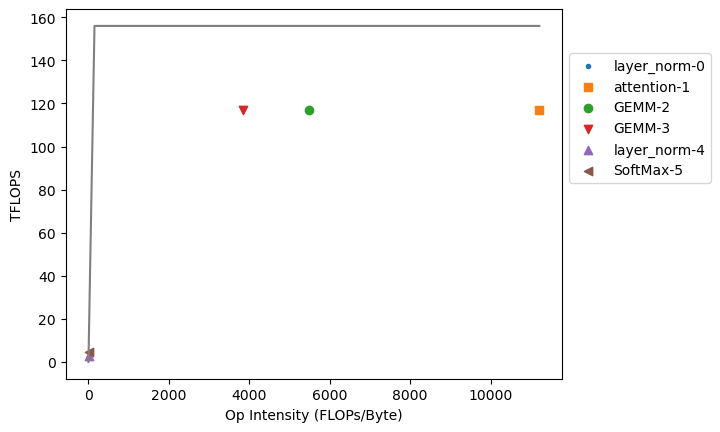

In [36]:

llama_on_a100_df = analysis_model(llama_7B_prefill(64), A100_GPU)
display(llama_on_a100_df)

dot_roofline(llama_on_a100_df, A100_GPU)
print(f'Total Cycles:{sum(llama_on_a100_df.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(llama_on_a100_df.loc[:, "Total Data (MB)"]):0.2f}')

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,layer_norm,"[64, 1, 2048]",M,0.02,8.01,0.00,789.47,2.10,0.12,0.00,0.12,0.25,2.91,19.65,789.47
1,attention,"[64, 1, 12288, 2048]",M,0.39,126.46,0.21,230130.25,9663.68,0.12,72.00,0.75,72.88,45.98,90442.12,230130.25
2,GEMM,"[64, 1, 49152, 2048]",M,0.39,123.93,0.29,313024.51,12881.76,0.12,96.00,3.00,99.12,45.06,120560.03,313024.51
3,GEMM,"[64, 1, 12288, 2048]",M,0.38,123.47,0.07,78552.18,3220.44,0.12,24.00,0.75,24.88,44.89,30140.01,78552.18
4,layer_norm,"[64, 1, 2048]",M,0.02,8.01,0.00,789.47,2.10,0.12,0.00,0.12,0.25,2.91,19.65,789.47
5,SoftMax,"[64, 4096]",M,0.04,12.50,0.00,1578.94,6.55,0.25,0.00,0.25,0.50,4.54,61.33,1578.94


Total Cycles:624864.82, Total data (MB): 197.88


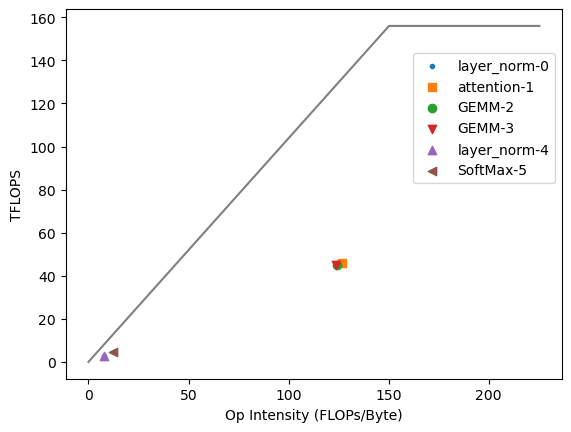

In [37]:
gpt3_on_a100_df = analysis_model(gpt3_175B_decode(64), A100_GPU)
display(gpt3_on_a100_df)

dot_roofline(gpt3_on_a100_df, A100_GPU)
print(f'Total Cycles:{sum(gpt3_on_a100_df.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(gpt3_on_a100_df.loc[:, "Total Data (MB)"]):0.2f}')

In [38]:
llama_on_a100_df.to_csv('output_a3i.csv', index=False)
gpt3_on_a100_df.to_csv('output_a3ii.csv', index=False)

## A.4 Compare on different Hardwares

### TODO A.4.i
Generate csv for llama and gpt3 on jetson nano system, with batch size 4. <br>
Make sure to name the csv file 'output_a4i.csv' and 'output_a4ii.csv'

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,layer_norm,"[4, 512, 4096]",M,0.01,8.00,2.45,1531862.75,134.29,8.00,0.00,8.00,16.00,0.05,9874.22,1531862.75
1,attention,"[4, 512, 4096, 4096]",C,2.68,3328.06,26.28,16422242.03,223342.49,8.00,48.00,8.00,64.00,8.50,16422242.03,6127450.98
2,GEMM,"[4, 512, 11008, 4096]",C,1.96,2429.06,21.72,13578018.33,184661.05,8.00,43.00,21.50,72.50,8.50,13578018.33,6941253.06
3,GEMM,"[4, 512, 4096, 4096]",C,1.65,2047.75,8.08,5052285.89,68711.09,8.00,16.00,8.00,32.00,8.50,5052285.89,3063725.49
4,layer_norm,"[4, 512, 4096]",M,0.01,8.00,2.45,1531862.75,134.29,8.00,0.00,8.00,16.00,0.05,9874.22,1531862.75
5,SoftMax,"[2048, 4096]",M,0.01,12.50,2.45,1531862.75,209.71,8.00,0.00,8.00,16.00,0.09,15420.08,1531862.75


Total Cycles:39648134.49, Total data (MB): 216.50


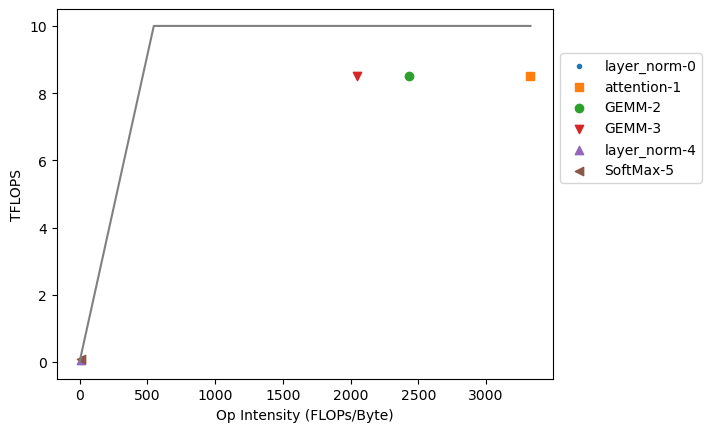

In [39]:

llama_on_jetson_nano_df = analysis_model(llama_7B_prefill(4), jetson_nano)
display(llama_on_jetson_nano_df)

dot_roofline(llama_on_jetson_nano_df, jetson_nano)
print(f'Total Cycles:{sum(llama_on_jetson_nano_df.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(llama_on_jetson_nano_df.loc[:, "Total Data (MB)"]):0.2f}')

llama_on_jetson_nano_df.to_csv('output_a4i.csv', index=False)


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,layer_norm,"[4, 1, 2048]",M,0.01,8.01,0.00,1495.96,0.13,0.01,0.00,0.01,0.02,0.05,9.65,1495.96
1,attention,"[4, 1, 12288, 2048]",M,0.01,7.99,11.04,6898618.21,603.98,0.01,72.00,0.05,72.05,0.05,44410.29,6898618.21
2,GEMM,"[4, 1, 49152, 2048]",M,0.01,7.98,14.74,9209875.97,805.11,0.01,96.00,0.19,96.20,0.05,59199.25,9209875.97
3,GEMM,"[4, 1, 12288, 2048]",M,0.01,7.98,3.68,2303029.98,201.28,0.01,24.00,0.05,24.05,0.05,14799.81,2303029.98
4,layer_norm,"[4, 1, 2048]",M,0.01,8.01,0.00,1495.96,0.13,0.01,0.00,0.01,0.02,0.05,9.65,1495.96
5,SoftMax,"[4, 4096]",M,0.01,12.50,0.00,2991.92,0.41,0.02,0.00,0.02,0.03,0.09,30.12,2991.92


Total Cycles:18417507.99, Total data (MB): 192.37


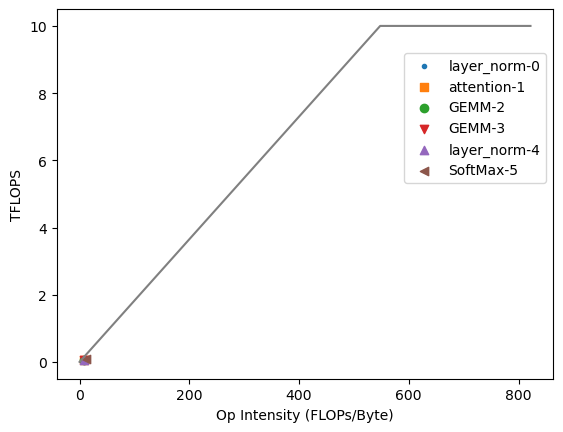

In [40]:
gpt3_on_jetson_nano_df = analysis_model(gpt3_175B_decode(4), jetson_nano)
display(gpt3_on_jetson_nano_df)

dot_roofline(gpt3_on_jetson_nano_df, jetson_nano)
print(f'Total Cycles:{sum(gpt3_on_jetson_nano_df.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(gpt3_on_jetson_nano_df.loc[:, "Total Data (MB)"]):0.2f}')

gpt3_on_jetson_nano_df.to_csv('output_a4ii.csv', index=False)


### TODO A.4.ii

Comment on the change in operator behavior between systems? Do they change, if so why?

Yes, there is a change, especially for GPT3 between the two systems.

Running GPT3 on the A100, we see that most of the operators (everything except layer_norm-4 and SoftMax-5) are near the part of the roofline plot when the line straightens. This means that they are not as memory bound as when using the Jetson Nano. On the Jetson Nano, all the operators are at the start of the roofline plot which indicates that the memory bandwidth is insufficient.

Running Llama on the A100, the positions of the operators relative to the shape of the plot do not change much compared to the same for the Jetson Nano. The GEMM operators have a higher relative operational intensity (in the position on the graph) for the Jetson Nano compared to the A100. The slope of the memory bound part of the roofline plot is steeper on the A100 compared to the Jetson Nano, which is consistent with higher memory bandwidth on the A100 compared to the Nano. There may not be as much change for Llama as it is a smaller model than GPT3 and has not hit the limits of the hardware yet.

### TODO A.4.iii

For running gpt3 175B decode, what changes would you suggest to on hardware specs that would help in optimizing the performance?

I would suggest to increase the memory bandwidth or memory efficiency to shift the operators to the right to be more compute bound since that seems to be the bottleneck according to the roofline plot.